# Heart Rate Estimation

The goal of this exercise is to estimate heart rate from PPG and acceleration signals. We signals from the PPG-DaLiA dataset (https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA). It includes PPG and acceleration signals as well as reference heart rate computed from an ECG signal.

These signals were collected during various activities but we focus on two of them: sitting and walking.

First, we import all the packages we will need, define some global variables, and seed the random number generators.

In [1]:
%matplotlib widget


import copy
import functools
import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch


DATA_FILE = pathlib.Path('../data/ppg_dalia.pkl')
LOG_DIRECTORY = pathlib.Path('../logs/hr_estimation')


# Disable logging for PyTorch Lightning to avoid too long outputs.
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

# Seed random number generators for reproducible results.
pl.seed_everything(42)

Seed set to 42


42

Then, we load the PPG and acceleration signals as well as the reference heart rate. The signals are already pre-processed with the following steps:

* Band-pass filtering between 0.4 and 4.0 Hz (24 - 240 bpm).
* Resampling to 25 Hz.

We also define the window length and shift length used to compute the reference heart rate.

In [2]:
FS = 25.0  # Sampling frequency of the PPG and acceleration signals in Hertz.
WINDOW_LENGTH = 8.0  # Window duration in seconds used to compute the reference heart rate.
SHIFT_LENGTH = 2.0  # Shift between successive windows in seconds.

WINDOW_SIZE = round(FS * WINDOW_LENGTH)
SHIFT_SIZE = round(FS * SHIFT_LENGTH)

records = joblib.load(DATA_FILE)
subjects = set(record['subject'] for record in records)

print(f'Window length: {WINDOW_LENGTH} s (n = {WINDOW_SIZE})')
print(f'Shift length: {SHIFT_LENGTH} s (n = {SHIFT_SIZE})')
print(f'Number of records: {len(records)}')
print(f'Number of subjects: {len(subjects)}')

Window length: 8.0 s (n = 200)
Shift length: 2.0 s (n = 50)
Number of records: 29
Number of subjects: 15


Here are two examples of PPG and acceleration signals. One recorded when the subject is sitting and one recorded when the subject is walking.

Each figure includes three plots: the tri-axis acceleration signals, the PPG signal, and a spectrogram of the PPG signal with the reference heart rate on top.

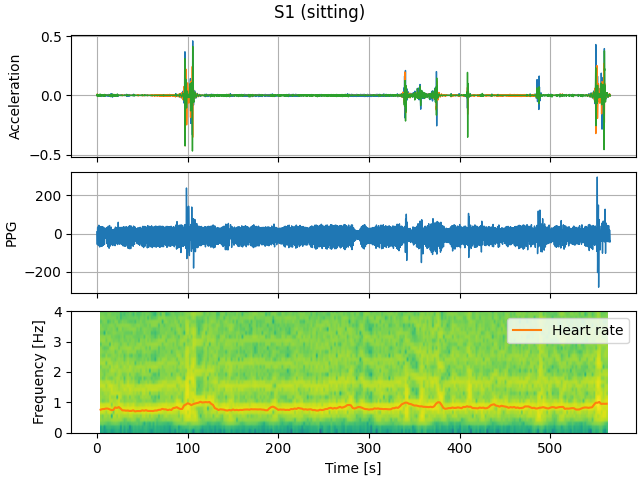

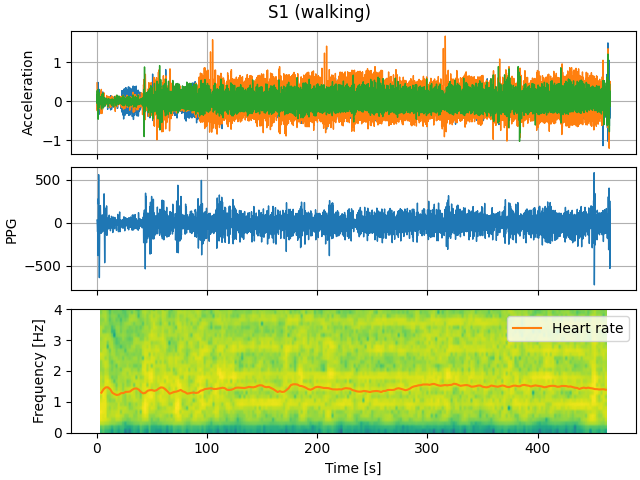

In [3]:
def plot_signals(record):
    signals = record['signals']
    hr = record['hr']

    fig, axes = plt.subplots(3, 1, sharex='all', constrained_layout=True)
    plt.suptitle(f'{record["subject"]} ({record["activity"]})')

    plt.sca(axes.flat[0])
    plt.plot(signals['time'].to_numpy(),
             signals[['acc_x', 'acc_y', 'acc_z']].to_numpy(),
             linewidth=1)
    plt.grid()
    plt.ylabel('Acceleration')

    plt.sca(axes.flat[1])
    plt.plot(signals['time'].to_numpy(), signals['ppg'].to_numpy(),
             linewidth=1)
    plt.grid()
    plt.ylabel('PPG')

    plt.sca(axes.flat[2])
    plt.specgram(signals['ppg'].to_numpy(), Fs=FS, NFFT=WINDOW_SIZE,
                 noverlap=WINDOW_SIZE - SHIFT_SIZE)
    plt.plot(hr['time'].to_numpy(), hr['hr'].to_numpy() / 60.0,
             color='tab:orange', label='Heart rate')
    plt.ylim(0.0, 4.0)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.legend(loc='upper right')
    
    
plot_signals(records[0])
plot_signals(records[1])

By zooming on the PPG signal, it is clear that walking cause a degradation in signal quality.

We will try to estimate the heart rate on sliding windows of the PPG and acceleration signals. To make things easier, we use the same window length and shift between windows as the reference heart rate.

So the next step is to extract sliding windows from all the records. We also extract the corresponding subject identifier for splitting the windows into subsets for training, validation, and testing.

In addition, we also prepare windows that include only the PPG signal (first channel).

In [4]:
def extract_windows(record):
    x = record['signals'][['ppg', 'acc_x', 'acc_y', 'acc_z']].to_numpy()
    n = x.shape[0]

    windows = []
    for start in range(0, n - WINDOW_SIZE + 1, SHIFT_SIZE):
        end = start + WINDOW_SIZE
        windows.append(x[start:end].T)
    windows = np.stack(windows)
    targets = record['hr']['hr'].to_numpy()

    return windows, targets


def extract_all_windows(records):
    windows = []
    targets = []
    subjects = []
    activities = []
    for record in records:
        x, y = extract_windows(record)
        windows.append(x)
        targets.append(y)
        subjects.extend(itertools.repeat(record['subject'], x.shape[0]))
        activities.extend(itertools.repeat(record['activity'], x.shape[0]))

    windows = np.concatenate(windows, axis=0)
    targets = np.concatenate(targets)[:, None]
    subjects = np.array(subjects)
    activities = np.array(activities)

    return windows, targets, subjects, activities


ppg_acc_windows, targets, subjects, activities = extract_all_windows(records)
ppg_windows = ppg_acc_windows[:, :1, :]

print(f'Shape of PPG and accleration windows: {ppg_acc_windows.shape}')
print(f'Shape of PPG windows: {ppg_windows.shape}')

Shape of PPG and accleration windows: (7420, 4, 200)
Shape of PPG windows: (7420, 1, 200)


We have 7420 windows with 1 or 4 channels and that each window includes 200 samples (8 seconds at 25 Hz).

Next, we split the windows for training, validation, and testing by subjects. The test set includes 9 subjects, the validation set 3 subjects, and the test set 3 subjects.

In [5]:
def split_subjects(subjects):
    val_subjects = ('S10', 'S11', 'S12')
    test_subjects = ('S13', 'S14', 'S15')

    i_val = np.flatnonzero(np.isin(subjects, val_subjects))
    i_test = np.flatnonzero(np.isin(subjects, test_subjects))
    i_train = np.setdiff1d(np.arange(subjects.size), np.union1d(i_val, i_test))

    assert not (set(subjects[i_train]) & set(subjects[i_val]))
    assert not (set(subjects[i_train]) & set(subjects[i_test]))
    assert not (set(subjects[i_val]) & set(subjects[i_test]))
    assert (set(subjects[i_train]) | set(subjects[i_val]) | set(subjects[i_test])) == set(subjects)

    return i_train, i_val, i_test


i_train, i_val, i_test = split_subjects(subjects)

print(f'Subject used for training   : {pd.unique(subjects[i_train])}')
print(f'Subject used for validation : {pd.unique(subjects[i_val])}')
print(f'Subject used for testing    : {pd.unique(subjects[i_test])}')

Subject used for training   : ['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9']
Subject used for validation : ['S10' 'S11' 'S12']
Subject used for testing    : ['S13' 'S14' 'S15']


To make training more stable, we scale the windows such that they have approximately unit variance.

In [6]:
def compute_scaling(windows):
    sigma = np.mean(np.std(windows, axis=-1, keepdims=True), axis=0)
    return 1.0 / sigma


ppg_acc_alpha = compute_scaling(ppg_acc_windows[i_train])
ppg_acc_windows *= ppg_acc_alpha
ppg_alpha = compute_scaling(ppg_windows[i_train])
ppg_windows *= ppg_alpha

**Question 1**

The windows are scaled but not centered. Why?

**Answer**

We can see in the cell below that the mean of the signal is already zero. Therefore there is no need to center the signal. When filtering (Band-Pass) the signal, the offset (zero frequency) is removed and the signal is centered.

In [24]:
ppg_windows.mean(axis=(0, 2))

array([-6.8200391e-05])

Now we define the convolutional neural network (CNN) we will use to estimate heart rate. It is composed of convolutional layers to extract features and dense layers to estimate heart rate. The convolutional layers can optionally include batch normalization and the dense layers dropout.

In [7]:
class CnnModel(torch.nn.Module):

    def __init__(self,
                 input_shape,
                 output_shape,
                 n_convolutional_layers=1,
                 kernel_size=5,
                 n_initial_channels=16,
                 use_normalization=False,
                 n_dense_layers=1,
                 n_units=128,
                 dropout=0.0):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.n_convolutional_layers = n_convolutional_layers
        self.kernel_size = kernel_size
        self.n_initial_channels = n_initial_channels
        self.use_normalization = use_normalization
        self.n_dense_layers = n_dense_layers
        self.n_units = n_units
        self.dropout = dropout
        self.layers = self._build_layers()

    @property
    def input_size(self):
        return functools.reduce(operator.mul, self.input_shape)

    @property
    def output_size(self):
        return functools.reduce(operator.mul, self.output_shape)

    def _build_layers(self):
        layers = self._build_convolutional_layers()
        layers.extend(self._build_dense_layers())
        return torch.nn.Sequential(*layers)

    def _build_convolutional_layers(self):
        layers = []

        n_output_channels = self.input_shape[0]
        for i in range(self.n_convolutional_layers):
            n_input_channels = n_output_channels
            n_output_channels = self.n_initial_channels * 2 ** i
            layers.append(torch.nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_output_channels,
                kernel_size=self.kernel_size,
                padding='same',
            ))
            if self.use_normalization:
                layers.append(torch.nn.BatchNorm1d(n_output_channels))
            layers.append(torch.nn.ReLU())
            if i < self.n_convolutional_layers - 1:
                layers.append(torch.nn.MaxPool1d(kernel_size=2))
            else:
                layers.append(torch.nn.AdaptiveAvgPool1d(1))
        layers.append(torch.nn.Flatten())

        return layers

    def _build_dense_layers(self):
        sizes = [self.n_initial_channels
                 * 2 ** (self.n_convolutional_layers - 1)]
        sizes.extend(itertools.repeat(self.n_units, self.n_dense_layers - 1))
        sizes.append(self.output_size)

        layers = []
        for i in range(self.n_dense_layers - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            layers.append(torch.nn.ReLU())
            if 0.0 < self.dropout < 1.0:
                layers.append(torch.nn.Dropout(self.dropout))
        layers.append(torch.nn.Linear(sizes[-2], sizes[-1]))

        return layers

    def forward(self, x):
        return self.layers(x)

We also define a class to specify how the model should be trained and evaluated and a few utility functions. It is also here that we select the mean squared error (MSE) as the loss function to optimize the parameters. We also compute the mean absolute error (MAE) as an additional metric to monitor training.

In [8]:
class Regressor(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = CnnModel(**self.config['model'])
        self.example_input_array = torch.zeros((1,) + self.model.input_shape)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), **self.config['optimizer'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        return self._run_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        self._run_step(batch, 'val')

    def test_step(self, batch, batch_idx):
        self._run_step(batch, 'test')

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.model(x)

    def _run_step(self, batch, subset):
        x, y = batch
        z = self.model(x)
        mse = torch.nn.functional.mse_loss(z, y)
        mae = torch.nn.functional.l1_loss(z, y)
        self.log_dict({
            f'{subset}_mse': mse,
            f'{subset}_mae': mae,
        }, on_step=False, on_epoch=True, prog_bar=True)
        return mse

    
def build_loader(*tensors, batch_size=100, shuffle=False, n_workers=0):
    dataset = torch.utils.data.TensorDataset(*map(torch.Tensor, tensors))
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_workers,
    )


def train_model(config, windows, targets, i_train, i_val, n_epochs, name):
    train_loader = build_loader(windows[i_train], targets[i_train], shuffle=True)
    val_loader = build_loader(windows[i_val], targets[i_val])
    regressor = Regressor(config)
    print(pl.utilities.model_summary.ModelSummary(regressor, max_depth=-1))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=pl.loggers.TensorBoardLogger(LOG_DIRECTORY, name),
            enable_model_summary=False,
            max_epochs=n_epochs,
        )
        trainer.fit(regressor, train_loader, val_loader)
    
    return regressor


def compute_metrics(targets, predictions):
    targets = targets.ravel()
    predictions = predictions.ravel()
    return {
        'count': targets.size,
        'mse': np.mean((targets - predictions) ** 2),
        'mae': np.mean(np.abs(targets - predictions)),
    }


def evaluate_model(model, windows, targets, i_train, i_val, i_test):
    loader = build_loader(windows, targets)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        predictions = trainer.predict(model, loader)
    predictions = np.vstack([p.numpy() for p in predictions])
    
    metrics = []
    for subset, indices in (('train', i_train), ('val', i_val), ('test', i_test)):
        metrics.append({
            'subset': subset,
            **compute_metrics(targets[indices], predictions[indices]),
        })
    return pd.DataFrame(metrics)

We also start TensorBoard to monitor training.

If you prefer to view TensorBoard in a separate window, you can open http://localhost:6006/ in your web browser.

In [28]:
%reload_ext tensorboard
%tensorboard --logdir ../logs/hr_estimation --port 6007

We are finally to define the first model configuration we will train. It includes the following layers:

* Input windows (input_size = 200, input channels = 1 or 4)
* Convolutional layer (kernel size = 5, output size = 200, output channels = 16)
* ReLU activation
* Max pooling (output size = 100, output channels = 16)
* Convolutional layer (kernel size = 5, output size = 100, output channels = 32)
* ReLU activation
* Max pooling (output size = 50, output channels = 32)
* Convolutional layer (kernel size = 5, output size = 50, output channels = 64)
* ReLU activation
* Max pooling (output size = 25, output channels = 64)
* Convolutional layer (kernel size = 5, output size = 25, output channels = 128)
* ReLU activation
* Global averaging pooling (output size = 128)
* Dense layer (output size = 128)
* ReLU activation
* Dense layer (output size = 128)
* ReLU activation
* Dense layer (output size = 1)

We use the same configuration for PPG only and PPG and acceleration windows (only the input shape changes).

We also define the number of epochs to use for training.

In [29]:
ppg_cnn_config = {
    'model': {
        'input_shape': ppg_windows.shape[1:],
        'output_shape': targets.shape[1:],
        'n_convolutional_layers': 4,
        'kernel_size': 5,
        'n_initial_channels': 16,
        'use_normalization': False,
        'n_dense_layers': 3,
        'n_units': 128,
        'dropout': 0.0,
    },
    'optimizer': {
        'lr': 0.0001,
    },
}
ppg_acc_cnn_config = copy.deepcopy(ppg_cnn_config)
ppg_acc_cnn_config['model']['input_shape'] = ppg_acc_windows.shape[1:]

n_epochs = 30

print('PPG CNN config')
IPython.display.display(ppg_cnn_config)
print()
print('PPG ACC CNN config')
IPython.display.display(ppg_acc_cnn_config)

PPG CNN config


{'model': {'input_shape': (1, 200),
  'output_shape': (1,),
  'n_convolutional_layers': 4,
  'kernel_size': 5,
  'n_initial_channels': 16,
  'use_normalization': False,
  'n_dense_layers': 3,
  'n_units': 128,
  'dropout': 0.0},
 'optimizer': {'lr': 0.0001}}


PPG ACC CNN config


{'model': {'input_shape': (4, 200),
  'output_shape': (1,),
  'n_convolutional_layers': 4,
  'kernel_size': 5,
  'n_initial_channels': 16,
  'use_normalization': False,
  'n_dense_layers': 3,
  'n_units': 128,
  'dropout': 0.0},
 'optimizer': {'lr': 0.0001}}

We are ready to train the first two models with these configurations.

In [30]:
ppg_cnn = train_model(
    config=ppg_cnn_config, 
    windows=ppg_windows, 
    targets=targets, 
    i_train=i_train, 
    i_val=i_val, 
    n_epochs=n_epochs, 
    name='ppg_cnn',
)

ppg_acc_cnn = train_model(
    config=ppg_acc_cnn_config, 
    windows=ppg_acc_windows, 
    targets=targets, 
    i_train=i_train, 
    i_val=i_val, 
    n_epochs=n_epochs, 
    name='ppg_acc_cnn',
)

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 87.2 K | train | [1, 1, 200]  | [1, 1]      
1  | model.layers    | Sequential        | 87.2 K | train | [1, 1, 200]  | [1, 1]      
2  | model.layers.0  | Conv1d            | 96     | train | [1, 1, 200]  | [1, 16, 200]
3  | model.layers.1  | ReLU              | 0      | train | [1, 16, 200] | [1, 16, 200]
4  | model.layers.2  | MaxPool1d         | 0      | train | [1, 16, 200] | [1, 16, 100]
5  | model.layers.3  | Conv1d            | 2.6 K  | train | [1, 16, 100] | [1, 32, 100]
6  | model.layers.4  | ReLU              | 0      | train | [1, 32, 100] | [1, 32, 100]
7  | model.layers.5  | MaxPool1d         | 0      | train | [1, 32, 100] | [1, 32, 50] 
8  | model.layers.6  | Conv1d            | 10.3 K | train | [1, 32, 50]  | [1, 64, 50] 
9  | model.layers.7  | ReL

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 87.5 K | train | [1, 4, 200]  | [1, 1]      
1  | model.layers    | Sequential        | 87.5 K | train | [1, 4, 200]  | [1, 1]      
2  | model.layers.0  | Conv1d            | 336    | train | [1, 4, 200]  | [1, 16, 200]
3  | model.layers.1  | ReLU              | 0      | train | [1, 16, 200] | [1, 16, 200]
4  | model.layers.2  | MaxPool1d         | 0      | train | [1, 16, 200] | [1, 16, 100]
5  | model.layers.3  | Conv1d            | 2.6 K  | train | [1, 16, 100] | [1, 32, 100]
6  | model.layers.4  | ReLU              | 0      | train | [1, 32, 100] | [1, 32, 100]
7  | model.layers.5  | MaxPool1d         | 0      | train | [1, 32, 100] | [1, 32, 50] 
8  | model.layers.6  | Conv1d            | 10.3 K | train | [1, 32, 50]  | [1, 64, 50] 
9  | model.layers.7  | ReL

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**Question 2**

Based on metrics shown in TensorBoard, does using the acceleration signals in addition to the PPG signal help to improve performance?

**Answer**
Yes, for the acceleration model, we found a RMSE of 278.6604 for the validation set, while 534.7772 for the normal one. This shows that using the acceleration signals indeed improve the model performances. It can also be seen in the plot below that the estimation is more accurate for the predictions with acceleration signals.

We plot the heart rate predicted by these two models for two records from the validation set: one where the subject is sitting and on where the subject is walking.

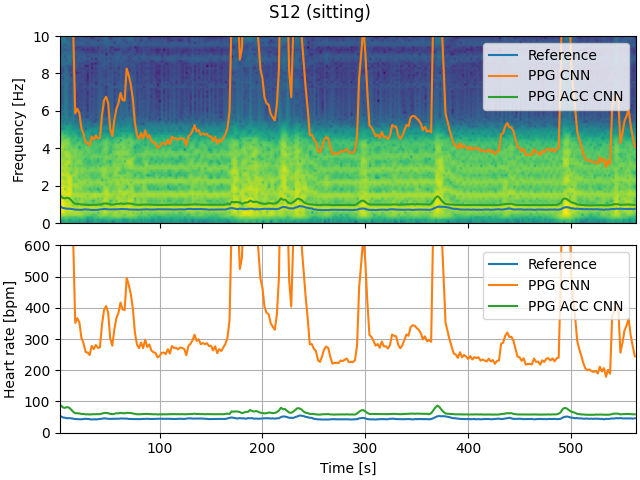

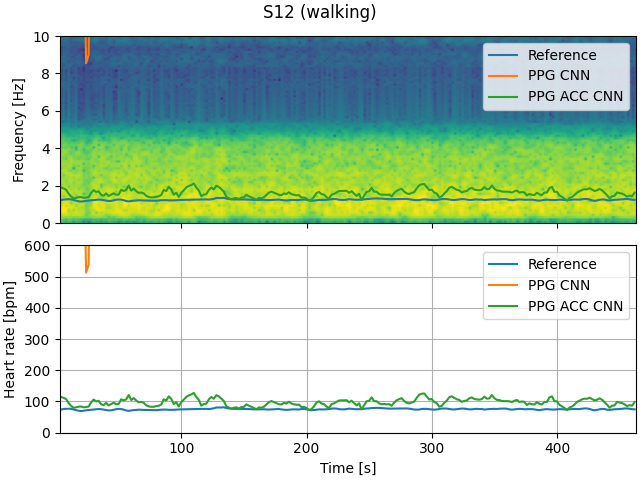

In [12]:
def apply_model(model, record, alpha):
    windows, targets = extract_windows(record)
    if alpha.shape[0] == 1:
        windows = windows[:, :1, :]
    windows *= alpha
    loader = build_loader(windows, targets)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        predictions = trainer.predict(model, loader)
    predictions = np.vstack([p.numpy() for p in predictions])
    
    return targets.ravel(), predictions.ravel()


def plot_results(record, models, limits=(0.0, 600.0)):
    predictions = {}
    for name, (model, alpha) in models.items():
        _, predictions[name] = apply_model(model, record, alpha)
    
    signals = record['signals']
    hr = record['hr']
    
    limits = np.array(limits)
    fig, axes = plt.subplots(2, 1, sharex='all', constrained_layout=True)
    plt.suptitle(f'{record["subject"]} ({record["activity"]})')
    plt.sca(axes.flat[0])
    plt.specgram(signals['ppg'].to_numpy(), Fs=FS, NFFT=WINDOW_SIZE,
                 noverlap=WINDOW_SIZE - SHIFT_SIZE)
    plt.plot(hr['time'].to_numpy(), hr['hr'].to_numpy() / 60.0,
             label='Reference')
    for name, prediction in predictions.items():
        plt.plot(hr['time'].to_numpy(), prediction / 60.0, label=name)
    plt.ylim(limits / 60.0)
    plt.ylabel('Frequency [Hz]')
    plt.legend(loc='upper right')
    plt.sca(axes.flat[1])
    plt.plot(hr['time'].to_numpy(), hr['hr'].to_numpy(), label='Reference')
    for name, prediction in predictions.items():
        plt.plot(hr['time'].to_numpy(), prediction, label=name)
    plt.ylim(limits)
    plt.grid()
    plt.xlabel('Time [s]')
    plt.ylabel('Heart rate [bpm]')
    plt.legend(loc='upper right')
    

models = {
    'PPG CNN': (ppg_cnn, ppg_alpha),
    'PPG ACC CNN': (ppg_acc_cnn, ppg_acc_alpha),
}

plot_results(records[21], models)
plot_results(records[22], models)

**Question 3**

What can you say about the predictions computed with the two models?

**Answer**
As already mentioned in Question 2, the prediction with the model including acceleration signals is way more accurate. We can see in Figure 3 that this prediction sticks more to the reality, while the PPG without acceleration does not make sense at all.

Next, we modify the configuration of the model using both PPG and acceleration to add batch normalization after each convolution layer. We do not do the same for the model using only PPG since it does not work at all.

In [31]:
ppg_acc_norm_cnn_config = copy.deepcopy(ppg_acc_cnn_config)
ppg_acc_norm_cnn_config['model']['use_normalization'] = True

print('PPG ACC norm CNN config')
IPython.display.display(ppg_acc_norm_cnn_config)

PPG ACC norm CNN config


{'model': {'input_shape': (4, 200),
  'output_shape': (1,),
  'n_convolutional_layers': 4,
  'kernel_size': 5,
  'n_initial_channels': 16,
  'use_normalization': True,
  'n_dense_layers': 3,
  'n_units': 128,
  'dropout': 0.0},
 'optimizer': {'lr': 0.0001}}

We train a model with this new configuration.

In [32]:
ppg_acc_norm_cnn = train_model(
    config=ppg_acc_norm_cnn_config, 
    windows=ppg_acc_windows, 
    targets=targets, 
    i_train=i_train, 
    i_val=i_val, 
    n_epochs=n_epochs, 
    name='ppg_acc_norm_cnn',
)

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 88.0 K | train | [1, 4, 200]  | [1, 1]      
1  | model.layers    | Sequential        | 88.0 K | train | [1, 4, 200]  | [1, 1]      
2  | model.layers.0  | Conv1d            | 336    | train | [1, 4, 200]  | [1, 16, 200]
3  | model.layers.1  | BatchNorm1d       | 32     | train | [1, 16, 200] | [1, 16, 200]
4  | model.layers.2  | ReLU              | 0      | train | [1, 16, 200] | [1, 16, 200]
5  | model.layers.3  | MaxPool1d         | 0      | train | [1, 16, 200] | [1, 16, 100]
6  | model.layers.4  | Conv1d            | 2.6 K  | train | [1, 16, 100] | [1, 32, 100]
7  | model.layers.5  | BatchNorm1d       | 64     | train | [1, 32, 100] | [1, 32, 100]
8  | model.layers.6  | ReLU              | 0      | train | [1, 32, 100] | [1, 32, 100]
9  | model.layers.7  | Max

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**Question 4**

What is the effect of batch normalization on the training procedure and on the performance metrics?

**Answer**
Using batch normalization helps the training loss to converge faster as it reduces the variance inside each batch. Furthermore, inspecting training and validation RMSE show that BN helps achieving lower values.

We plot the predicted heart rate with respect to the reference for these new models (and we drop the one that did not work at all).

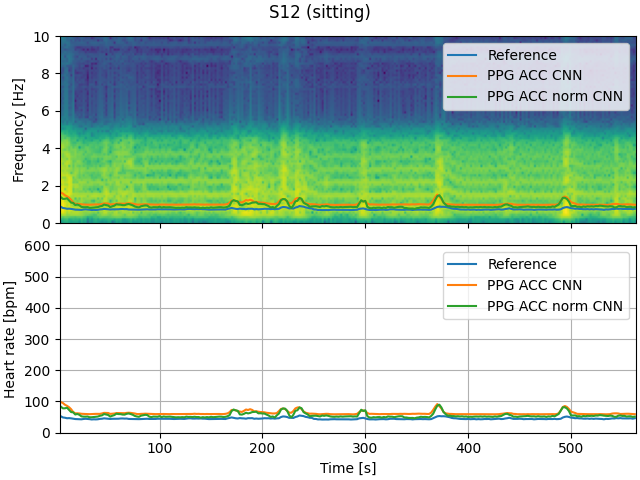

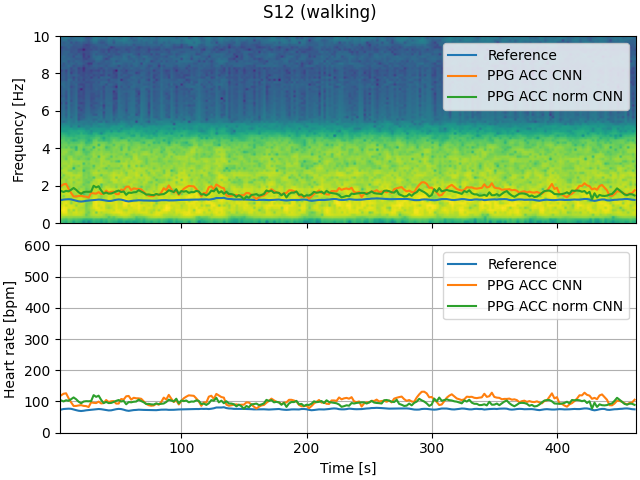

In [33]:
models = {
    'PPG ACC CNN': (ppg_acc_cnn, ppg_acc_alpha),
    'PPG ACC norm CNN': (ppg_acc_norm_cnn, ppg_acc_alpha), 
}

plot_results(records[21], models)
plot_results(records[22], models)

**Question 5**

Visually, is there a large difference between the CNN models with and without batch normalization on these examples?

**Anser**
No, visually, no clear difference can be observed between the two predictions.

Finally, we try another configuration where we add dropout after each dense layer (except the last one which is the output layer).

In [35]:
ppg_acc_norm_dropout_cnn_config = copy.deepcopy(ppg_acc_norm_cnn_config)
ppg_acc_norm_dropout_cnn_config['model']['dropout'] = 0.5

print('PPG ACC norm dropout CNN config')
IPython.display.display(ppg_acc_norm_dropout_cnn_config)

PPG ACC norm dropout CNN config


{'model': {'input_shape': (4, 200),
  'output_shape': (1,),
  'n_convolutional_layers': 4,
  'kernel_size': 5,
  'n_initial_channels': 16,
  'use_normalization': True,
  'n_dense_layers': 3,
  'n_units': 128,
  'dropout': 0.5},
 'optimizer': {'lr': 0.0001}}

And we train a new model with this configuration.

In [36]:
ppg_acc_norm_dropout_cnn = train_model(
    config=ppg_acc_norm_dropout_cnn_config, 
    windows=ppg_acc_windows, 
    targets=targets, 
    i_train=i_train, 
    i_val=i_val, 
    n_epochs=n_epochs, 
    name='ppg_acc_norm_dropout_cnn',
)

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 88.0 K | train | [1, 4, 200]  | [1, 1]      
1  | model.layers    | Sequential        | 88.0 K | train | [1, 4, 200]  | [1, 1]      
2  | model.layers.0  | Conv1d            | 336    | train | [1, 4, 200]  | [1, 16, 200]
3  | model.layers.1  | BatchNorm1d       | 32     | train | [1, 16, 200] | [1, 16, 200]
4  | model.layers.2  | ReLU              | 0      | train | [1, 16, 200] | [1, 16, 200]
5  | model.layers.3  | MaxPool1d         | 0      | train | [1, 16, 200] | [1, 16, 100]
6  | model.layers.4  | Conv1d            | 2.6 K  | train | [1, 16, 100] | [1, 32, 100]
7  | model.layers.5  | BatchNorm1d       | 64     | train | [1, 32, 100] | [1, 32, 100]
8  | model.layers.6  | ReLU              | 0      | train | [1, 32, 100] | [1, 32, 100]
9  | model.layers.7  | Max

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**Question 6**

Does using dropout help to reduce overfitting compare to the same model without dropout?

**Answer**
Yes, applying dropout reduces overfitting. This can be observed since MSE and MAE are slightly higher for the training set when applying Dropout. This can be explained since dropout randomly selects nodes at each steps, preventing nodes to be too specific to the data. Nevertheless, this difference remains small.

Again, we plot the predicted heart rate for two records from the validation set.

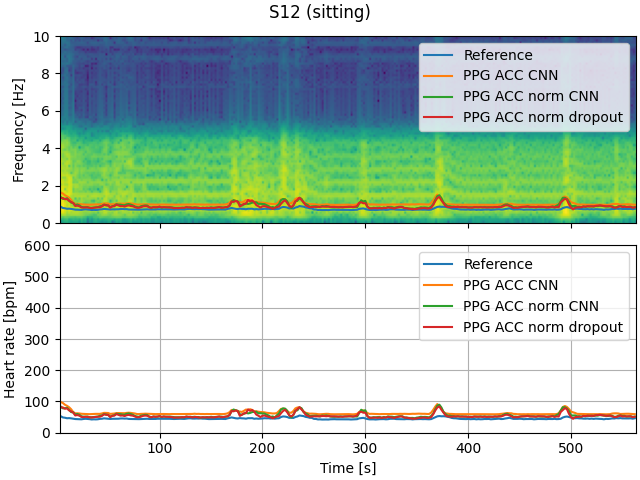

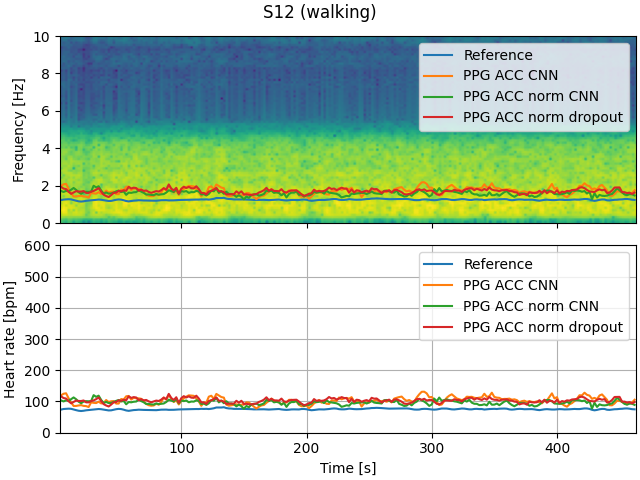

In [37]:
models = {
    'PPG ACC CNN': (ppg_acc_cnn, ppg_acc_alpha),
    'PPG ACC norm CNN': (ppg_acc_norm_cnn, ppg_acc_alpha),
    'PPG ACC norm dropout': (ppg_acc_norm_dropout_cnn, ppg_acc_alpha),
}

plot_results(records[21], models)
plot_results(records[22], models)

Finally, we compute performance metrics (MSE and MAE) for all models on the subsets for training, validation, and testing.

In [19]:
models = {
    'PPG CNN': ppg_cnn,
    'PPG ACC CNN': ppg_acc_cnn,
    'PPG ACC norm CNN': ppg_acc_norm_cnn,
    'PPG ACC norm dropout': ppg_acc_norm_dropout_cnn,
}

metrics = []
for name, model in models.items():
    if 'ACC' in name:
        windows = ppg_acc_windows
    else:
        windows = ppg_windows
    df = evaluate_model(model, windows, targets, i_train, i_val, i_test)
    df.insert(0, 'model', name)
    metrics.append(df)
metrics = pd.concat(metrics, axis=0, ignore_index=True)
metrics = metrics.set_index(['model', 'subset'])
index = metrics.index.get_level_values(0).unique()
columns = pd.MultiIndex.from_product([metrics.columns, metrics.index.get_level_values(1).unique()])
metrics = metrics.unstack().reindex(index=index, columns=columns)
IPython.display.display(metrics)

count                     mse                          \
subset               train   val  test       train         val        test   
model                                                                        
PPG CNN               4360  1530  1530  253.105415  519.009044  199.510891   
PPG ACC CNN           4360  1530  1530  127.893587  263.449593  198.234142   
PPG ACC norm CNN      4360  1530  1530   27.097020  230.597111   71.887220   
PPG ACC norm dropout  4360  1530  1530   30.607524  240.611002   60.324805   

                            mae                        
subset                    train        val       test  
model                                                  
PPG CNN               12.369010  19.012989  12.443980  
PPG ACC CNN            8.779760  13.099361  12.045710  
PPG ACC norm CNN       3.844666  11.438116   6.177527  
PPG ACC norm dropout   4.044759  11.505437   5.498473

**Question 7**

What is the best model in terms of MSE and MAE? What can you say about batch normalizaton and dropout?

**Answer**
Based on the table, the best mse, as well as the mae on the test set is achieved for the model with batch normalization and dropout. This highlights the theoretical aspects of both methods, effectively preventing overfitting.
But regarding the validation set, the model without dropout seems to perform better. With this difference, it is therefore difficult to ensure that dropout really helps in this case. 